In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(0)
#%matplotlib tk

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

NUM_SAMPLES = int(2e3)

brand_spend = np.random.rand(NUM_SAMPLES)
d2c_spend = np.random.rand(NUM_SAMPLES)
individual_contributions = brand_spend * .01 + d2c_spend * .02
collaboration = np.square(brand_spend) * d2c_spend * 10
sales = individual_contributions + collaboration + np.random.rand(NUM_SAMPLES)/10


def model_sales_regression(dataset, model='Ridge'):
    num_samples = dataset.shape[0]
    cutoff = (num_samples * 3) // 4
    Xtrn = dataset.drop('sales', 1).iloc[:cutoff,:]
    Ytrn = dataset['sales'].iloc[:cutoff]
    Xval = dataset.drop('sales', 1).iloc[cutoff:,:]
    Yval = dataset['sales'].iloc[cutoff:]
    model = Ridge().fit(Xtrn, Ytrn)
    coefs = model.coef_.round(2)
    yhat = model.predict(dataset.drop('sales', 1))
    yhatval = model.predict(Xval)
    loss = np.square(Yval - yhatval).mean()
    
    print('learned coefficients', list(zip(X.columns, coefs)))
    print('loss:', loss)
    print('intercept', model.intercept_.round(2))
    
    return model, yhat, coefs, loss

def graph_real_and_predicted(dataset, yhat, fname=None):
    X = dataset.drop('sales', 1)
    Y = dataset['sales']
    X1 = X['brand']
    X2 = X['d2c']
    fig = plt.figure(dpi=80, figsize=(10, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X1, X2, Y, c='r', label='real sales', s = 1)
    ax.scatter(X1, X2, yhat, c='b', label='estimated sales', s = 1)
    ax.set_xlabel('Brand Marketing')
    ax.set_ylabel('Direct to Consumer')
    ax.set_zlabel('Sales')
    plt.legend()
    if fname is not None:
        plt.savefig('images/' + fname + '.jpg')


<IPython.core.display.Javascript object>


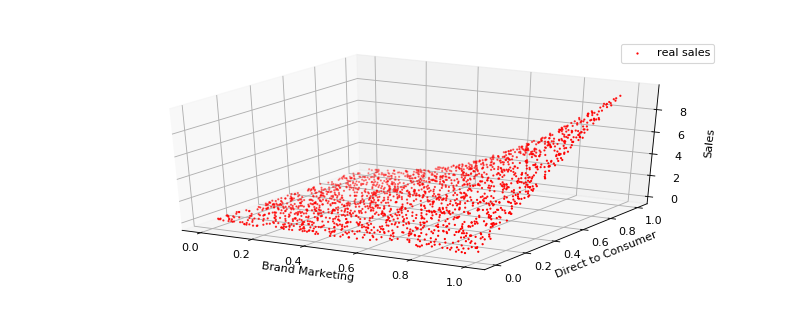

In [2]:

dataset = pd.DataFrame({
    'brand': brand_spend,
    'd2c': d2c_spend,
    'sales': sales
}).round(5)

X = dataset.drop('sales', 1)
Y = dataset['sales']
X1 = X['brand']
X2 = X['d2c']
fig = plt.figure(dpi=80, figsize = (10, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, c='r', label='real sales', s = 1)
ax.set_xlabel('Brand Marketing')
ax.set_ylabel('Direct to Consumer')
ax.set_zlabel('Sales')
plt.legend()
plt.savefig('images/data.jpg')


learned coefficients [('brand', 4.96), ('d2c', 3.32)]
loss: 0.8876355863216772
intercept -2.44


<IPython.core.display.Javascript object>


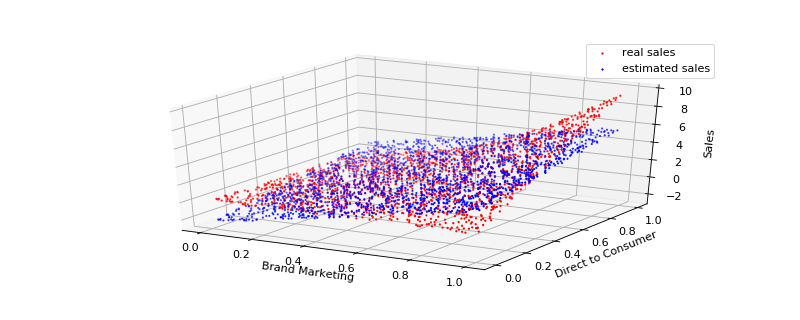

In [3]:

model, yhat, coefs, loss = model_sales_regression(dataset)
graph_real_and_predicted(dataset, yhat, 'linear')

learned coefficients [('brand', 0.54), ('d2c', -1.15)]
loss: 0.16027314415815522
intercept -0.2


<IPython.core.display.Javascript object>


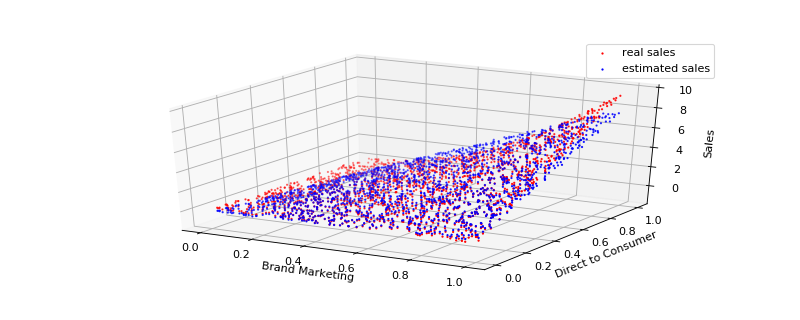

In [4]:
dataset['brand * d2c'] = dataset['brand'] * dataset['d2c']
model, yhat, coefs, loss = model_sales_regression(dataset)
graph_real_and_predicted(dataset, yhat, 'feature_engineering')

In [5]:

def model_sales_MLP(dataset, hidden, print_coefs = True, max_iter= 10000):
    num_samples = dataset.shape[0]
    cutoff = (num_samples * 3) // 4
    Xtrn = dataset.drop('sales', 1).iloc[:cutoff,:]
    Ytrn = dataset['sales'].iloc[:cutoff]
    Xval = dataset.drop('sales', 1).iloc[cutoff:,:]
    Yval = dataset['sales'].iloc[cutoff:]
    model = MLPRegressor(hidden, validation_fraction = 0, solver='lbfgs', max_iter= max_iter).fit(Xtrn, Ytrn)
    coefs = model.coefs_
    yhat = model.predict(X)
    yhatval = model.predict(Xval)
    loss = np.square(Yval - yhatval).mean()
    hiddens = coefs[0].T
    final_mlp = coefs[1].flatten()
    
    coefs = list(zip([dict(zip(X.columns, h)) for h in hiddens],
                     [['output mult:', m] for m in  final_mlp.flatten()], 
                     [['intercept:', i] for i in  model.intercepts_[0]]))
    print('loss:', loss)
    if print_coefs:
        for idx, c in enumerate(coefs):
            f1, o, i = c
            print('feature', idx, '=', f1['brand'].round(2), '* brand +', 
                  f1['d2c'].round(2), '* d2c', '+', i[1].round(2))
        output = 'yhat = '
        for fidx, v in enumerate(final_mlp):
            output = output + str(v.round(2)) + ' * feat ' + str(fidx) + ' + '
        output = output + str(model.intercepts_[1][0].round(2))
        print(output)
    return model, yhat, coefs, loss

loss: 0.1219398330725093
feature 0 = 1.32 * brand + 0.3 * d2c + 0.73
feature 1 = -0.18 * brand + -0.71 * d2c + 0.97
feature 2 = 2.76 * brand + 1.96 * d2c + -2.75
feature 3 = 1.6 * brand + 1.09 * d2c + 0.92
feature 4 = -0.47 * brand + 0.8 * d2c + 2.05
feature 5 = 0.35 * brand + 0.99 * d2c + -1.48
yhat = -0.19 * feat 0 + -0.42 * feat 1 + 3.39 * feat 2 + 1.11 * feat 3 + -0.63 * feat 4 + 0.66 * feat 5 + 0.31


<IPython.core.display.Javascript object>


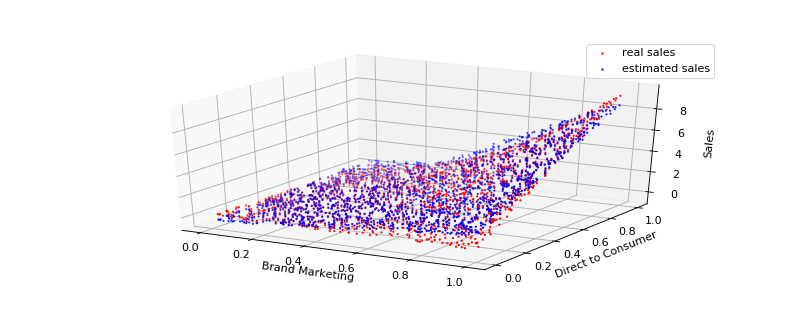

In [6]:

dataset = pd.DataFrame({
    'brand': brand_spend,
    'd2c': d2c_spend,
    'sales': sales
}).round(5)

model, yhat, coefs, loss = model_sales_MLP(dataset, [6])
graph_real_and_predicted(dataset, yhat, 'neural_network')

In [7]:
for idx, c in enumerate(coefs):
    f1, o, i = c
    print('feature', idx, '=', f1['brand'].round(2), '* brand +', f1['d2c'].round(2), '* d2c', '+', i[1].round(2))

feature 0 = 1.32 * brand + 0.3 * d2c + 0.73
feature 1 = -0.18 * brand + -0.71 * d2c + 0.97
feature 2 = 2.76 * brand + 1.96 * d2c + -2.75
feature 3 = 1.6 * brand + 1.09 * d2c + 0.92
feature 4 = -0.47 * brand + 0.8 * d2c + 2.05
feature 5 = 0.35 * brand + 0.99 * d2c + -1.48


loss: 0.0010987294809894682


<IPython.core.display.Javascript object>


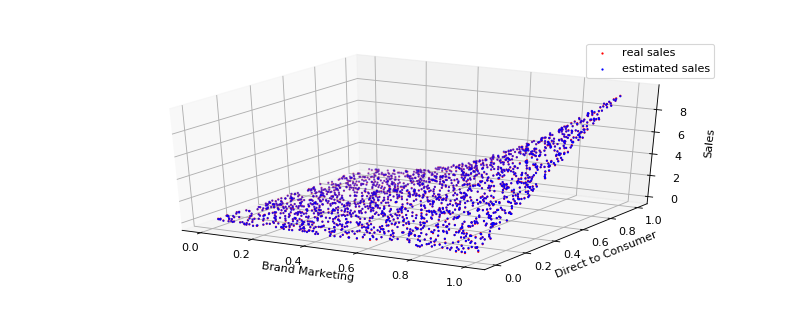

In [8]:

model, yhat, coefs, loss = model_sales_MLP(dataset, [100, 100], max_iter = 1000, print_coefs=False)
graph_real_and_predicted(dataset, yhat, fname = None)